# Import Libraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.api import MNLogit
import statsmodels as sm

1. Load the dataset and drop the following columns: StoreID and Store7

In [106]:
data = pd.read_csv('data/OJ.csv')
data.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


No missing vals

In [107]:
data_clean = data.drop(['Store7', 'StoreID'], axis=1)
data_clean.describe()

,WeekofPurchase,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,254.381308,1.867421,2.085411,0.051860,0.123364,0.147664,0.161682,0.565782,1.962047,1.815561,0.146486,0.059298,0.027314,0.217991,1.630841
std,15.558286,0.101970,0.134386,0.117474,0.213834,0.354932,0.368331,0.307843,0.252697,0.143384,0.271563,0.101760,0.062232,0.107535,1.430387
min,227.000000,1.690000,1.690000,0.000000,0.000000,0.000000,0.000000,0.000011,1.190000,1.390000,-0.670000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,1.790000,1.990000,0.000000,0.000000,0.000000,0.000000,0.325257,1.690000,1.750000,0.000000,0.000000,0.000000,0.140000,0.000000
50%,257.000000,1.860000,2.090000,0.000000,0.000000,0.000000,0.000000,0.600000,2.090000,1.860000,0.230000,0.000000,0.000000,0.240000,2.000000
75%,268.000000,1.990000,2.180000,0.000000,0.230000,0.000000,0.000000,0.850873,2.130000,1.890000,0.320000,0.112676,0.000000,0.300000,3.000000
max,278.000000,2.090000,2.290000,0.500000,0.800000,1.000000,1.000000,0.999947,2.290000,2.090000,0.640000,0.402010,0.252688,0.440000,4.000000


2. Convert the Purchase variable to categorical numbers

"A factor with levels ‘CH’ and ‘MM’ indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice"

In [108]:
data_clean['Purchase'].value_counts()

Purchase
CH    653
MM    417
Name: count, dtype: int64

In [109]:
data_clean['Purchase'] = data_clean['Purchase'].map({'CH': 0, 'MM': 1})
data_clean['Purchase'].value_counts()

Purchase
0    653
1    417
Name: count, dtype: int64

3. Produce some numerical and graphical summaries of the dataset.

In [110]:
def find_highest_correlations(corr_matrix):
    """function to find the highest correlation in a correlation matrix, with respect to each column"""
    for column in corr_matrix.columns:
        # Exclude the diagonal element by replacing it with NaN
        corr_column = corr_matrix[column].copy()
        corr_column[column] = None

        # Find the variable with the highest correlation
        highest_corr_value = corr_column.max()
        highest_corr_variable = corr_column.idxmax()
        
        print(f"Column '{column}' has highest correlation with '{highest_corr_variable}' : {highest_corr_value:.2f}")

In [111]:
def condense_upper_triangular(corr_matrix):
    """function to condense the upper triangular part of a correlation matrix into a DataFrame"""
    rows, cols = corr_matrix.shape
    condensed_list = []
    
    for i in range(rows):
        for j in range(i+1, cols):
            if not np.isnan(corr_matrix.iloc[i, j]):
                condensed_list.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    condensed_df = pd.DataFrame(condensed_list, columns=['Variable 1', 'Variable 2', 'Correlation'])
    return condensed_df

In [112]:
corr_matrix = data_clean.corr()
# only need upper triangular part of the correlation matrix, due to symmetry
corr_filtered = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_filtered = condense_upper_triangular(corr_filtered)
print(corr_filtered[abs(corr_filtered['Correlation']) > 0.5])

         Variable 1     Variable 2  Correlation
7          Purchase        LoyalCH    -0.640582
15   WeekofPurchase        PriceCH     0.704324
16   WeekofPurchase        PriceMM     0.576872
29          PriceCH        PriceMM     0.616402
36          PriceCH    SalePriceCH     0.586716
47          PriceMM    SalePriceMM     0.532859
52          PriceMM  ListPriceDiff     0.665187
55           DiscCH      SpecialCH     0.534775
59           DiscCH    SalePriceCH    -0.711274
62           DiscCH      PctDiscCH     0.999022
68           DiscMM    SalePriceMM    -0.846868
70           DiscMM      PriceDiff    -0.823908
71           DiscMM      PctDiscMM     0.998793
78        SpecialCH    SalePriceCH    -0.508586
81        SpecialCH      PctDiscCH     0.549015
100     SalePriceMM      PriceDiff     0.852798
101     SalePriceMM      PctDiscMM    -0.856749
107     SalePriceCH      PctDiscCH    -0.722776
110       PriceDiff      PctDiscMM    -0.828097


In [113]:
find_highest_correlations(corr_matrix)

Column 'Purchase' has highest correlation with 'SpecialMM' : 0.17
Column 'WeekofPurchase' has highest correlation with 'PriceCH' : 0.70
Column 'PriceCH' has highest correlation with 'WeekofPurchase' : 0.70
Column 'PriceMM' has highest correlation with 'ListPriceDiff' : 0.67
Column 'DiscCH' has highest correlation with 'PctDiscCH' : 1.00
Column 'DiscMM' has highest correlation with 'PctDiscMM' : 1.00
Column 'SpecialCH' has highest correlation with 'PctDiscCH' : 0.55
Column 'SpecialMM' has highest correlation with 'PctDiscMM' : 0.47
Column 'LoyalCH' has highest correlation with 'WeekofPurchase' : 0.19
Column 'SalePriceMM' has highest correlation with 'PriceDiff' : 0.85
Column 'SalePriceCH' has highest correlation with 'PriceCH' : 0.59
Column 'PriceDiff' has highest correlation with 'SalePriceMM' : 0.85
Column 'PctDiscMM' has highest correlation with 'DiscMM' : 1.00
Column 'PctDiscCH' has highest correlation with 'DiscCH' : 1.00
Column 'ListPriceDiff' has highest correlation with 'PriceMM

In [114]:
def box_per_store(data, y_value):
    """function to plot boxplot of y_value across stores"""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='STORE', y=y_value, data=data)
    plt.title(f'Boxplot of {y_value} across Stores')
    plt.show()

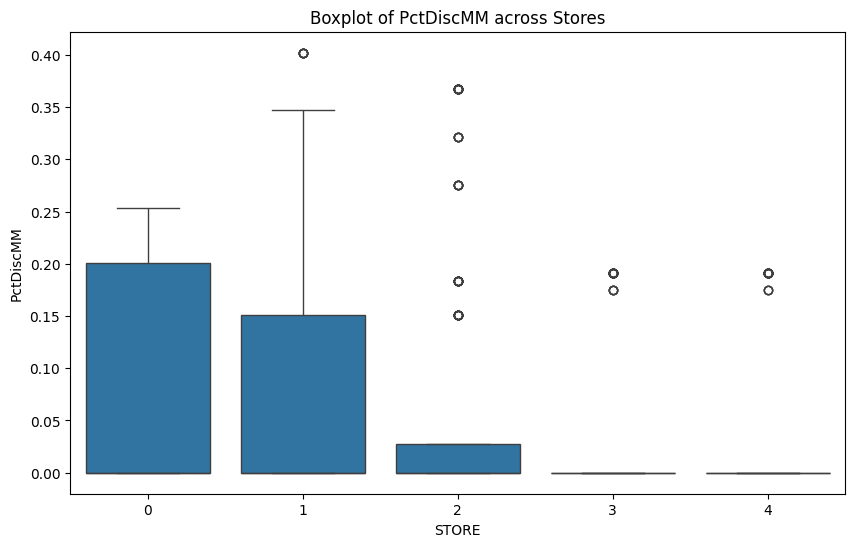

In [115]:
box_per_store(data_clean, 'PctDiscMM')

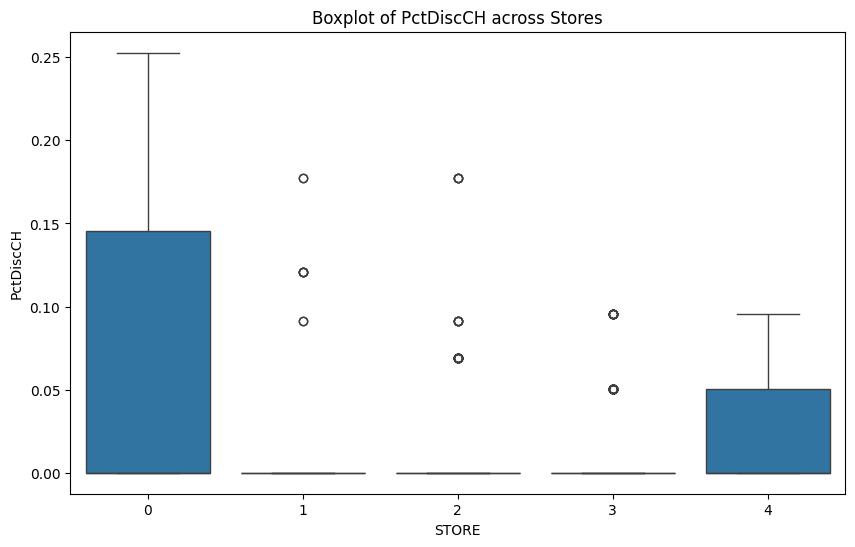

In [116]:
box_per_store(data_clean, 'PctDiscCH')

In [117]:
def scatter_over_time(data, y_value, class_var):
    """function to plot some feature over time (WeekofPurchase), differentiated by class_var"""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='WeekofPurchase', y=y_value, data=data, hue=class_var)
    plt.title(f'Scatterplot of {y_value} vs WeekofPurchase')
    plt.show()

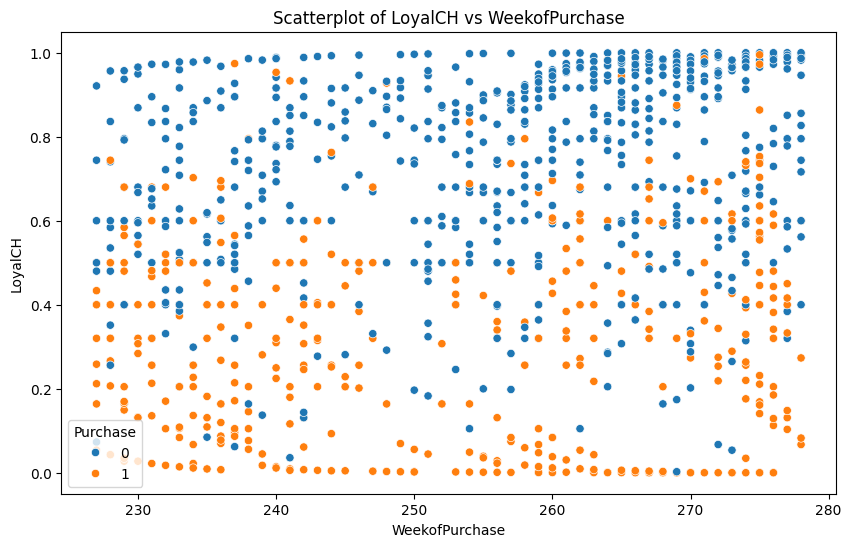

In [118]:
scatter_over_time(data_clean, 'LoyalCH', 'Purchase')

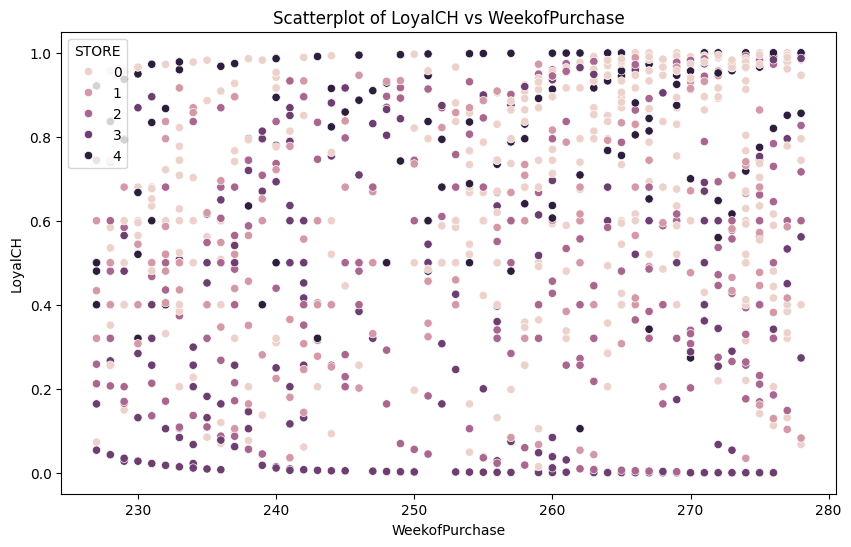

In [119]:
scatter_over_time(data_clean, 'LoyalCH', 'STORE')

4. Make STORE the response and the rest of the variables the predictors. Split the dataset into 80% training and 20% testing with random_state = 42

In [120]:
X = data_clean.drop('STORE', axis=1)
y = data_clean['STORE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((856, 15), (214, 15))

In [192]:
y.value_counts()

STORE
0    356
2    222
3    196
1    157
4    139
Name: count, dtype: int64

5. Train and test a multinomial logistic regression. Use the summary function to print the results.

In [189]:
X_train = sm.tools.tools.add_constant(X_train)
model = MNLogit(y_train, X_train).fit()
summary = model.summary()
tables = summary.tables[1]
tables

         Current function value: 0.881739
         Iterations: 35


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:5475: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


STORE=1,coef,std err,z,P>|z|,[0.025,0.975]
const,11.1568,3.275,3.407,0.001,4.738,17.575
Purchase,0.4171,0.333,1.253,0.210,-0.235,1.070
WeekofPurchase,0.0769,0.016,4.718,0.000,0.045,0.109
PriceCH,-13.1468,3.24e+06,-4.06e-06,1.000,-6.34e+06,6.34e+06
PriceMM,-5.0532,8.84e+05,-5.72e-06,1.000,-1.73e+06,1.73e+06
DiscCH,-16.7066,nan,nan,nan,nan,nan
DiscMM,-3.2893,nan,nan,nan,nan,nan
SpecialCH,-1.7387,0.493,-3.525,0.000,-2.705,-0.772
SpecialMM,0.9493,0.376,2.528,0.011,0.213,1.685
LoyalCH,-0.6297,0.540,-1.167,0.243,-1.688,0.428


In [190]:
df = pd.DataFrame(tables.data)
df.head()

,0,1,2,3,4,5,6
0,STORE=1,coef,std err,z,P>|z|,[0.025,0.975]
1,const,11.1568,3.275,3.407,0.001,4.738,17.575
2,Purchase,0.4171,0.333,1.253,0.210,-0.235,1.070
3,WeekofPurchase,0.0769,0.016,4.718,0.000,0.045,0.109
4,PriceCH,-13.1468,3.24e+06,-4.06e-06,1.000,-6.34e+06,6.34e+06


In [188]:
# Identify the rows where STORE numbers appear
store_rows = df[0].str.contains("STORE=", na=False)

# Extract the sections for each store
store_dfs = {}
store_numbers = df[0][store_rows].unique()

for store in store_numbers:
    start_idx = df[df[0] == store].index[0]
    if store != store_numbers[-1]:
        end_idx = df[df[0] == store_numbers[list(store_numbers).index(store) + 1]].index[0]
    else:
        end_idx = len(df)
    store_dfs[store] = df.iloc[start_idx + 1:end_idx]

# Convert columns to appropriate types
for store, store_df in store_dfs.items():
    store_df.columns = ["Variable", "coef", "std err", "z", "P>|z|", "[0.025", "0.975]"]
    store_df.set_index("Variable", inplace=True)

p_values = pd.DataFrame({store: store_df['P>|z|'] for store, store_df in store_dfs.items()})
p_values

,STORE=1,STORE=2,STORE=3,STORE=4
Variable,,,,
const,0.001,0.284,0.021,0.003
Purchase,0.210,0.059,0.371,0.076
WeekofPurchase,0.000,0.048,0.000,0.000
PriceCH,1.000,1.000,1.000,nan
PriceMM,1.000,nan,nan,1.000
DiscCH,nan,1.000,nan,1.000
DiscMM,nan,1.000,nan,1.000
SpecialCH,0.000,0.001,0.195,0.494
SpecialMM,0.011,0.000,0.000,0.026


In [191]:
summary.tables[0]

Dep. Variable:,STORE,No. Observations:,856
Model:,MNLogit,Df Residuals:,808
Method:,MLE,Df Model:,44
Date:,"Wed, 26 Jun 2024",Pseudo R-squ.:,0.4317
Time:,12:52:41,Log-Likelihood:,-754.77
converged:,False,LL-Null:,-1328.2
Covariance Type:,nonrobust,LLR p-value:,1.577e-211


6. Compute the confusion matrix and the test accuracy

In [122]:
X_test = sm.tools.tools.add_constant(X_test)
y_pred = model.predict(X_test)
y_pred = y_pred.idxmax(axis=1)
print(confusion_matrix(y_test, y_pred))

[[53  2  9  3  4]
 [11 10  6  1  1]
 [17  1 25  5  3]
 [ 6  0  1 24  5]
 [ 6  0  0  8 13]]


In [123]:
print(accuracy_score(y_test, y_pred))

0.5841121495327103


In [124]:
def plot_decision_boundary(X, y, model, feature1, feature2):
    """Function to plot the decision boundary of a model."""
    plt.figure(figsize=(10, 6))

    # For title of the plot
    model_type = ""
    if model.__class__.__name__ == 'MultinomialResultsWrapper':
        model_type = "Multinomial Logistic Regression"
    elif model.__class__.__name__ == 'LinearDiscriminantAnalysis':
        model_type = "Linear Discriminant Analysis"
    elif model.__class__.__name__ == 'GaussianNB':
        model_type = "Naive Bayes"
    elif model.__class__.__class__.__name__ == 'KNeighborsClassifier':
        model_type = "K-Nearest Neighbors"
    
    # Select two features for plotting
    X_selected = X[[feature1, feature2]]
    
    sns.scatterplot(x=X_selected[feature1], y=X_selected[feature2], hue=y, palette='viridis')
    
    x_min, x_max = X_selected[feature1].min() - 1, X_selected[feature1].max() + 1
    y_min, y_max = X_selected[feature2].min() - 1, X_selected[feature2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Prepare the grid for prediction
    if (model.__class__.__name__ == 'MultinomialResultsWrapper'):
        grid_full = np.zeros((grid.shape[0], X.shape[1] + 1))  # +1 for the constant term
        grid_full[:, 1 + X.columns.get_loc(feature1)] = grid[:, 0]
        grid_full[:, 1 + X.columns.get_loc(feature2)] = grid[:, 1]
        grid_full[:, 0] = 1  # constant term

    else:
        grid_full = np.zeros((grid.shape[0], X.shape[1]))
        grid_full[:, X.columns.get_loc(feature1)] = grid[:, 0]
        grid_full[:, X.columns.get_loc(feature2)] = grid[:, 1]
    
    # Set other features to their mean values
    for col in X.columns:
        if col != feature1 and col != feature2:
            grid_full[:, X.columns.get_loc(col)] = X[col].mean()
    
    # If it's Logistic Regression, handle the prediction differently
    if model.__class__.__name__ == 'MultinomialResultsWrapper':
        # Predict class probabilities
        Z = model.predict(grid_full)
        # Find the class with the highest probability
        Z = np.argmax(Z, axis=1)
    else:
        # Convert grid_full back to DataFrame to silence warnings
        grid_full_df = pd.DataFrame(grid_full, columns=X.columns)
        Z = model.predict(grid_full_df)
    
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'Decision Boundary of {model_type}')
    plt.show()

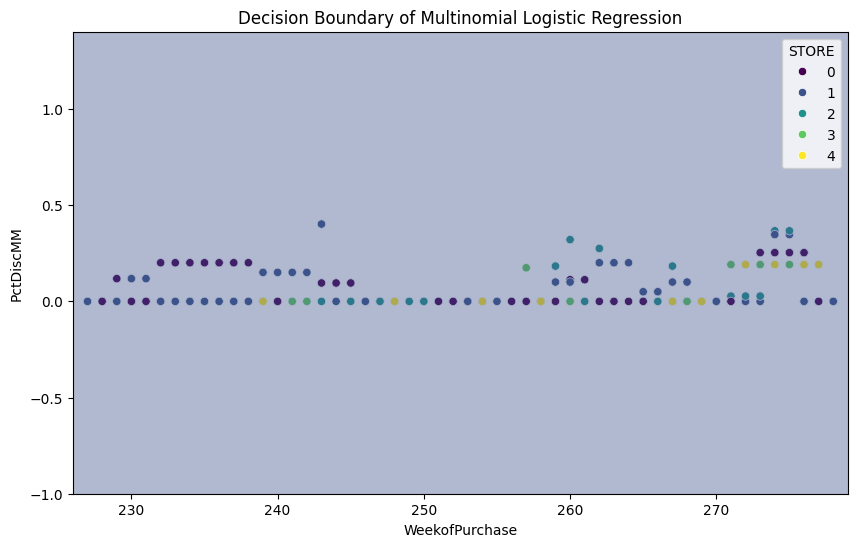

In [125]:
plot_decision_boundary(X, y, model, 'WeekofPurchase', 'PctDiscMM')

7. Repeat (5) and (6) using LDA

In [126]:
lda = LinearDiscriminantAnalysis()
X_train = X_train.drop('const', axis=1)
X_test = X_test.drop('const', axis=1)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[48  7  9  3  4]
 [ 8 10  8  2  1]
 [15  3 24  5  4]
 [ 6  0  1 24  5]
 [ 2  0  0  8 17]]
0.5747663551401869


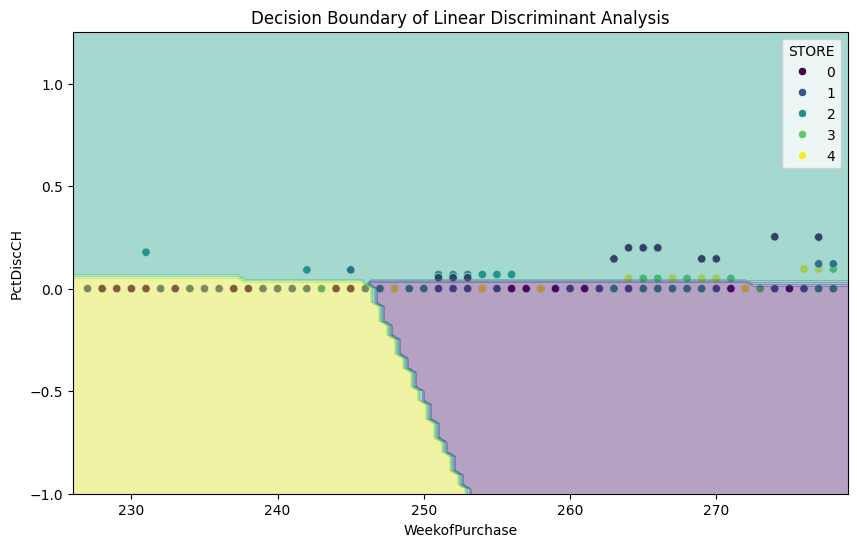

In [127]:
plot_decision_boundary(X, y, lda, 'WeekofPurchase', 'PctDiscCH')

7. Repeat (5) and (6) using KNN with K = 1

In [128]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[65  2  2  2  0]
 [ 4 14  8  2  1]
 [ 5 13 27  3  3]
 [ 2  1  1 24  8]
 [ 2  0  1 12 12]]
0.6635514018691588


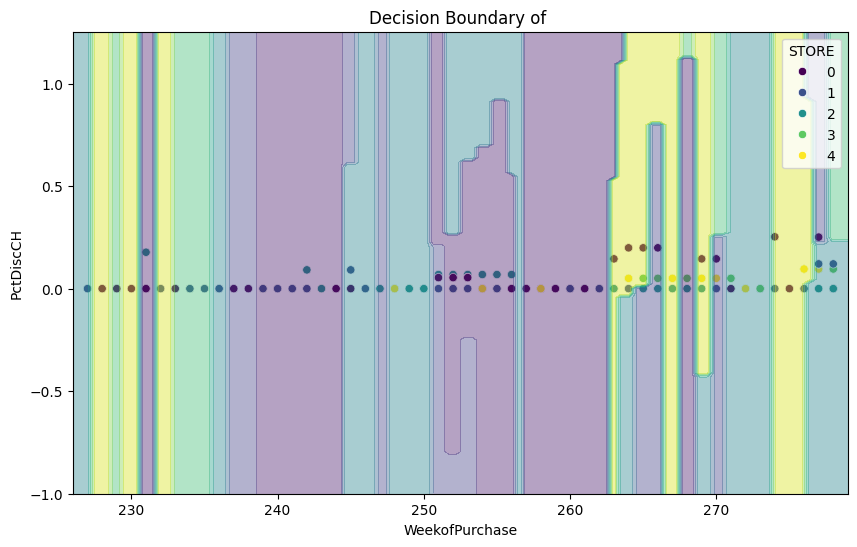

In [129]:
plot_decision_boundary(X, y, knn, 'WeekofPurchase', 'PctDiscCH')

8. Repeat (5) and (6) using naive Bayes

In [130]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[33  9  4 14 11]
 [ 3  9  9  5  3]
 [ 9 10 14 13  5]
 [ 2  1  3 27  3]
 [ 0  3  0 13 11]]
0.4392523364485981


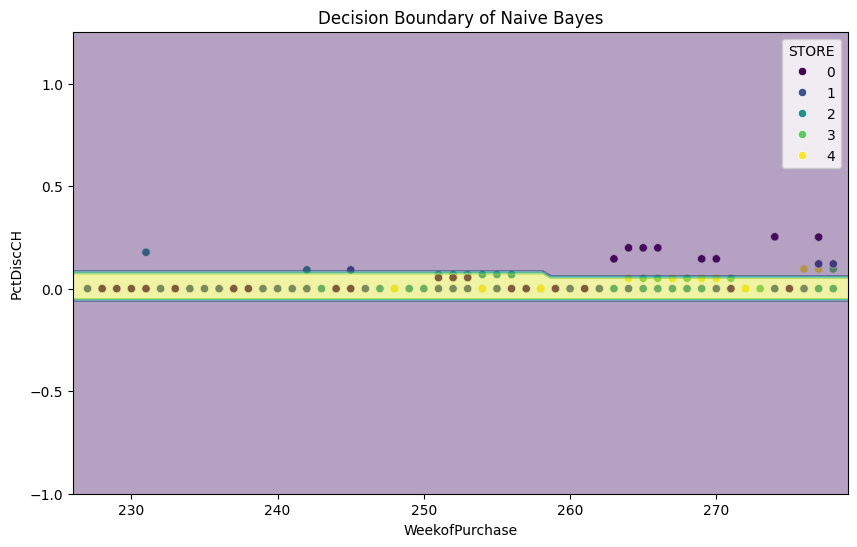

In [131]:
plot_decision_boundary(X, y, nb, 'WeekofPurchase', 'PctDiscCH')